# Demo Notebook

## Import libraries

In [1]:
import time
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.stats import qmc
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pocomc as pc
import pickle
import os

SEED = 0
np.random.seed(seed=SEED)

n_cpus = os.cpu_count() 
print('This machine has {} CPUs'.format(n_cpus))

This machine has 8 CPUs


## An class-based approach to model calibration

The model class has the following attributes:
1. `x_n` : `int`
    Number of species in the model
2. `fit_x0` : `bool`
    Whether the initial conditions are to be estimated and are therefore include in `theta` args.
3. `x0` : `list[float], optional`
    The initial conditions of model species
4. `theta_n` : `int`
    Number of parameters to be fit. This includes ALL parameters to be estimated which MAY include initial conditions and the standard deviation of the model species. The order of the model parameters in this list is assumed to be as follows:
    1. ODE equation parameters
    2. Initial conditions (denoted $x_\#$, **optional**)
    3. Species standard deviations (denoted $\sigma_\#$)
5. `theta_true` : `list[float]` of shape `(theta_n)`
    True theta values of the model system. The order of 
6. `theta_names` : `list[str]` of shape `(theta_n)`
    Name of parameters for plotting purposes
7. `lower_bnds` : `list[float]` of shape `(theta_n)`
    Lower bounds of parameter values 
8. `upper_bnds` : `list[float]` of shape `(theta_n)`
    Upper bounds of parameter values 
9. `ts` : `list[float]` 
    Experimental data times 
10. `data` : `list[float]` of shape `(x_n, ts)` 
    Experimental data used for model calibration
11. `sys_fun` : `callable` 
    Model function used to solve system ODEs. It will be called by `solve_ivp`.

In [2]:
class Model:
    def __init__(self, opts): #initial settings
        for key in opts: #loops for all labels in the list 'key'
            setattr(self, key, opts[key]) #creates a dictionary where 'key' are the list of labels & 'ops[key]' are the values

    def run_sim(self, model_param = None, x0=None): #takes in canidate parameters then solves the ode
        if model_param is None:
            model_param= self.theta_true[:self.ODE_params_n]  #sets the model_params to just the model parameters
        if x0 is None:
            x0 = self.x0 #if x0 not defined, default x0 to the model x0
        t_span = (self.ts[0], self.ts[-1]) #define the time span
        x_n = self.x_n 
        #print(self.ts)
        result = solve_ivp(self.sys_fun, t_span, y0=x0, 
                        t_eval=self.ts.astype(np.float64), args=([model_param])) #solve ODE (with model parameters)
        
        return result #returns result.t and result.y
    
    def log_prior(self, theta_new): 
        bools = [(low <= i <= high) for i,low,high in zip(theta_new, self.lower_bnds, self.upper_bnds)] #if generated values are within bounds
        all_in_range = np.all(bools) #if all values are true, then output is true
        if all_in_range: #if true
            return 0.0 #give 0
        return -np.inf #if even one parameter out of bounds, it's false, and returns -infinity

    def log_likelihood(self, theta_new): #how good is this canidate parameter fitting my data (maximize it)
        model_param = theta_new[:self.ODE_params_n] 
        if self.fit_x0: 
            x0 = theta_new[self.ODE_params_n:(self.ODE_params_n + self.x_n)] #sets x0 to 'theta_true' x0 values
        else:
            x0 = self.x0

        if self.fit_sigma:
            sigma = theta_new[-len(self.observable_index):] #observable index related to sigma
        else:
            sigma = [1] * len(self.observable_index) #makes all sigmas default to 1

        y = self.run_sim(model_param=model_param, x0= x0).y #sets y to the y results of solving ODE
        y = y.astype(np.float64)
        #print("Y SHAPE: ", y.shape)
        #print("DATA.SHAPE: ", self.data.shape)
        data = self.data.astype(np.float64) #sets data
        if self.x_n > 1:
            y = np.transpose(y)

        # Calculate posterior; how good is parameter in terms of fitting the data
        #sigma = theta_new[-(self.x_n):]  
        term1 = -0.5 * np.log(2*np.pi*np.square(sigma))
        print("\ny shape: ", y.shape)
        print("data shape: ", data.shape)
        #print((np.subtract(y, data)).shape)
        #print(np.square(sigma).shape)
        term2 = np.square(np.subtract(y, data)) / (2*np.square(sigma))
        logLH = np.sum(term1 - term2)
        return logLH

## Create model 3 object

In [3]:
# Model 4 Options
mod4_opts = {} #creates a dictionary
mod4_opts['theta_n'] = 11 #total number of values in big array
mod4_opts['ODE_params_n'] = 5 # num ODE params
mod4_opts['x_n'] = 3 # num species
mod4_opts['sigma_n'] = 3 # num sigmas
mod4_opts['theta_names'] = ['$kappa$', '$k_2$', '$k_3$', '$k_4$', '$k_5$', '$x_1$', '$x_2$', '$x_3$', '$\sigma_1$', '$\sigma_2$', '$\sigma_3$'] #names of the parameters (for dictionary)
mod4_opts['fit_x0'] = True # fit initial conditions?
mod4_opts['x0'] = [0] # initial conditions (if given)
mod4_opts['observable_index'] = [0,1,2]
mod4_opts['fit_sigma'] = True #fit sigma?
mod4_opts['theta_true'] = [3.8,1,1,1,1,1,1,1,0.75,0.32,0.46] # true param values
mod4_opts['lower_bnds'] = [1,0.8,0.8,0.8,0.8,0,0,0,1E-2,1E-2,1E-2] #lower bounds
mod4_opts['upper_bnds'] = [5,1.2,1.2,1.2,1.2,2,2,2,2,2,2] #upper bounds

# load data for model 3
mod4_df = pd.read_csv('m4_data.csv', header=0, delimiter =",") #reads in data file
mod4_opts['ts'] = mod4_df['t'].values.astype(np.float64) #sets data under 't' in csv as 'ts'
mod4_opts['data'] = mod4_df[['x1','x2','x3']].values.T #reshape(1, len(mod3_opts['ts'])) #makes data array and reshapes it
data = mod4_opts['data']
data = np.transpose(data)
#data[:,[2,0]] = data[:,[0,2]]
#data[:,[2,1]] = data[:,[1,2]]
mod4_opts['data'] = data

def mod4_sys(t, y, theta): #makes a new function
    x1, x2, x3 = y 
    kappa, k2, k3, k4, k5 = theta #, x1, x2, sigma1, sigma2
    dx1dt = (kappa -k4)*x1 - k2*x1*x2
    dx2dt = -(k3*x2) + k5*x3
    dx3dt = k4*x1 - k5*x3
    return [dx1dt, dx2dt, dx3dt] #the ode given in paper for model 2

mod4_opts['sys_fun'] = mod4_sys
mod4 = Model(mod4_opts) #calls mod3 the Model class with the mod3_opts parameters!

# Sanity checks with log_prior
test_theta = [5,1.2,1.2,1.2,1.2,2,2,2,0.01,0.01,0.01] # This should return 0.0 
print(mod4.log_prior(test_theta))
test_bad_theta1 = [0,1.2,1.2,1.2,1.2,2,2,2,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta1))
test_bad_theta2 = [5,0,1.2,1.2,1.2,2,2,2,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta2))
test_bad_theta3 = [5,1.2,0,1.2,1.2,2,2,2,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta3))
test_bad_theta4 = [5,1.2,1.2,0,1.2,2,2,2,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta4))
test_bad_theta5 = [5,1.2,1.2,1.2,0,2,2,2,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta5))
test_bad_theta6 = [5,1.2,1.2,1.2,1.2,-1,2,2,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta6))
test_bad_theta7 = [5,1.2,1.2,1.2,1.2,2,-1,2,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta7))
test_bad_theta8 = [5,1.2,1.2,1.2,1.2,2,2,-1,0.01,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta8))
test_bad_theta9 = [5,1.2,1.2,1.2,1.2,2,2,2,-1,0.01,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta9))
test_bad_theta10 = [5,1.2,1.2,1.2,1.2,2,2,2,0.01,-1,0.01] # should return -np.inf
print(mod4.log_prior(test_bad_theta10))
test_bad_theta11 = [5,1.2,1.2,1.2,1.2,2,2,2,0.01,0.01,-1] # should return -np.inf
print(mod4.log_prior(test_bad_theta11))

# Sanity checks with log_likelihood
print(mod4.log_likelihood(mod4.theta_true))
print(mod4.log_likelihood([5,1.2,1.2,1.2,1.2,2,2,2,0.01,0.01,0.01]))

0.0
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf

y shape:  (101, 3)
data shape:  (101, 3)
-393.3224294202257

y shape:  (101, 3)
data shape:  (101, 3)
-43823036.980551094


#delete later
model_param = mod4.theta_true[:mod4.ODE_params_n] 
x0 = mod4.theta_true[mod4.ODE_params_n:(mod4.ODE_params_n + mod4.x_n)]
sigma = mod4.theta_true[-len(mod4.observable_index):]
y = mod4.run_sim(model_param=model_param, x0= x0).y #sets y to the y results of solving ODE
data = mod4.data #sets data
y = np.transpose(y)
print(y.shape)
print(mod4.data.shape)
print(np.shape(sigma))

term1 = -0.5 * np.log(2*np.pi*np.square(sigma))
print(np.shape(term1))
term2 = np.square(np.subtract(y, data)) / (2*np.square(sigma))
print(np.shape(term2))
logLH = np.sum(term1 - term2)
print(logLH)

## Test model simulation and plot model trajectory with $\theta_{true}$ vs experimental data

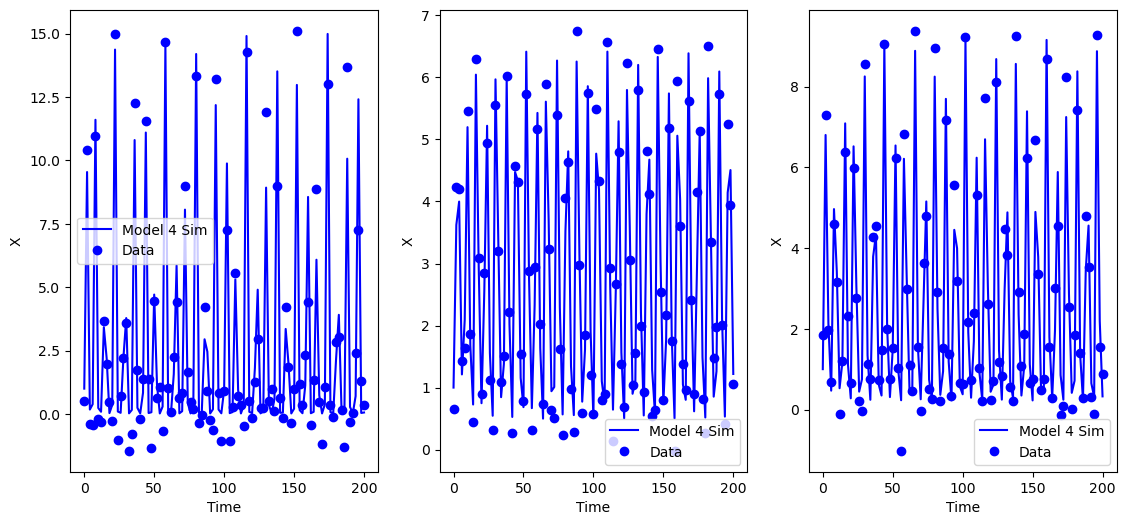

In [4]:
#t_span = (mod2_opts['ts'][0], mod2_opts['ts'][-1])
# Test solve_ivp
#result = solve_ivp(mod2_sys, t_span, y0=[0], t_eval=mod2_opts['ts'], args=([mod2_opts['theta_true']]))

# Setup
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13.5,6)) #plotting three subplots next to each other
result = mod4.run_sim(mod4_opts['theta_true'][0:5], mod4_opts['theta_true'][5:8] ) #run the simulation on model 2 parameters
#mod2_opts['theta_true'][0:3], mod2_opts['theta_true'][4:5] 

#First Subplot
plt.subplot(1,3,1)
plt.plot(result.t, (result.y[0,:]), 'b-', label='Model 4 Sim') #plot the simulations generated model
plt.plot(mod4_opts['ts'], (mod4_opts['data'][:,0]), 'bo', label='Data') #plot data points from cv
plt.legend(); plt.xlabel('Time'); plt.ylabel('X'); #label axes

#Second Subplot
plt.subplot(1,3,2)
plt.plot(result.t, (result.y[1,:]), 'b-', label='Model 4 Sim') #plot the simulations generated model
plt.plot(mod4_opts['ts'], (mod4_opts['data'][:,1]), 'bo', label='Data') #plot data points from cv
plt.legend(); plt.xlabel('Time'); plt.ylabel('X'); #label axes

#Third Subplot
plt.subplot(1,3,3)
plt.plot(result.t, (result.y[2,:]), 'b-', label='Model 4 Sim') #plot the simulations generated model
plt.plot(mod4_opts['ts'], (mod4_opts['data'][:,2]), 'bo', label='Data') #plot data points from cv
plt.legend(); plt.xlabel('Time'); plt.ylabel('X'); #label axes

## Sample initial parameter sets using Latin Hypercube Sampling

In [5]:
n_particles = 1000 #amount of points in the latin hypercube sampling?

# Initialise particles' positions using samples from the prior (this is very important, other initialisation will not work).
sampler = qmc.LatinHypercube(d=mod4.theta_n, seed=SEED) #d is amount of parameters being solved for in model 3
sample = sampler.random(n=n_particles) #causes sample to be an array of n_particles x mod3.theta_n (1000x3)  
print("The discrepancy of the sampling (i.e., sample quality): %.4f"%qmc.discrepancy(sample)) #discrepancy is distance between cont. uniform distr. on hypercube & discr. uniform distr. on n distinct sample points
prior_samples = qmc.scale(sample, l_bounds=mod4.lower_bnds, u_bounds=mod4.upper_bnds) #widens/narrows sample to be within the bounds given
print(prior_samples.shape)

The discrepancy of the sampling (i.e., sample quality): 0.0052
(1000, 11)


## Run pocoMC
This might take a little bit

In [6]:
t0 = time.time() #stores current time, date, year, etc. in one float
#with Pool(n_cpus) as pool: #sets up code to run over my n number of cpus on laptop

sampler = pc.Sampler(n_particles = n_particles,
                n_dim = mod4.theta_n,
                log_likelihood = mod4.log_likelihood,
                log_prior = mod4.log_prior,
                bounds = np.array(list(zip(mod4.lower_bnds, mod4.upper_bnds))),
                random_state=SEED
                ) #stores all relevant info from # of parameters being fit (ndim) to the actual results

sampler.run(prior_samples = prior_samples) #starts with prior sample definied in latin hypercube sampling, and runs it
result = sampler.results #results of sampler.run on prior_samples


with open('tester_result.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL) #saves result object (dictionary) to pickle file

with open('tester_mod4.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(mod4.__dict__, f, protocol=pickle.HIGHEST_PROTOCOL) #saves model 3 dictionary in pickle file

t1 = time.time() #time after running this section
seconds = t1-t0 #difference in start and stop time

elapsed = time.strftime("%H:%M:%S", time.gmtime(seconds)) #converts float to a time quantity we use
print('\nElapsed time: ', elapsed) #printing time it took for code to run


y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (

Iter: 1it [00:00, 314.46it/s, beta=2.03e-6, calls=1000, ESS=0.949, logZ=-.102, accept=0.234, N=0, scale=1]


y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (101, 3)

y shape:  (101, 3)
data shape:  (

ValueError: operands could not be broadcast together with shapes (24,3) (101,3) 

## Load and plot results

In [ ]:
temp = {} #creates new dictionary
with open('tester_result.pkl', 'rb') as handle: #opens result pickle file under 'handle'
    b = pickle.load(handle) #loads pickle file and calls is b
    temp = b #sets up b as the object dictionary called temp
print(temp.keys()) #prints the labels of all the dictionary values stored in each row (15 total)
samps = temp['samples'] #assigns samps matrix as arrays under 'samples' label in temp dictionary
xs = temp['x'] #assigns xs matrix as arrays under 'x' label in temp dictionary
print(xs.shape) #prints matrix size of xs
print(samps.shape) #prints matrix size of samps

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4.75)) #plotting three subplots next to each other

axs[0].hist(samps[:, 0]); axs[0].set_title(mod3.theta_names[0]); #plotting all the generated possible parameters for parameter 1
axs[0].axvline(x=mod3.theta_true[0], color='r', ls='--', label='True Value'); #plots where expected true value
axs[0].axvline(x=mod3.lower_bnds[0], color='k', ls='--'); #plots lower bound
axs[0].axvline(x=mod3.upper_bnds[0], color='k', ls='--'); #plots upper bound
axs[0].legend(); #legend

axs[1].hist(samps[:, 1]); axs[1].set_title(mod3.theta_names[1]); #plotting all the generated possible parameters for parameter 2
axs[1].axvline(x=mod3.theta_true[1], color='r', ls='--', label='True Value'); #plots where expected true value
axs[1].axvline(x=mod3.lower_bnds[1], color='k', ls='--'); #plots lower bound
#axs[1].axvline(x=mod3.upper_bnds[1], color='k', ls='--', label='Max');
axs[1].legend(); #legend

axs[2].hist(samps[:, 2]); axs[2].set_title(mod3.theta_names[2]); #plotting all the generated possible parameters for parameter 3
axs[2].axvline(x=mod3.theta_true[2], color='r', ls='--', label='True Value'); #plots where expected true value
axs[2].axvline(x=mod3.lower_bnds[2], color='k', ls='--'); #plots lower bound
axs[2].axvline(x=mod3.upper_bnds[2], color='k', ls='--'); #plots upper bound
axs[2].set_xscale('log') #set x-axis as log scale
axs[2].legend(); #legend


In [ ]:
# Visualize trajectory and corner plots
pc.plotting.corner(temp) #corner plot of the 1-D and 2-D marginal posteriors
plt.show() #show plot
#posterior is how good is a parameter in terms of fitting the data
#plots the last samples of the possible values of the parameters
#corner plots show how corelated the different parameters are to each other!

sim_data = [] #creates a list
t_range = mod3.ts #sets time range
sigma = mod3.theta_true[-1] #sets the fitted sigma as sigma used in plots
for params in temp['samples']: #generates the different tragectories from the different generated parameters (at a confidence interval)
    sim_data.append(np.random.normal(mod3.run_sim(params)['y'], sigma))

sim_data = np.array(sim_data) #converts sim_data to an array
print(sim_data) #prints those generated trajectories

d = np.genfromtxt('m3_data.csv', delimiter=',') #bringing in data from csv file, using ',' to seperate data points
t = d[:,0] #sets t as time for data points
data = d[:,1] #sets data for data points

plt.figure(figsize=(8,6)) #set up a figure
plt.fill_between(t_range, np.percentile(sim_data,2.5,axis=0).flatten(),np.percentile(sim_data,97.5,axis=0).flatten(),alpha=0.5, label=r'$95\%$ CI') #plots 95% CI trajectories
plt.errorbar(x=t, y=data, yerr=sigma, marker='o', ls=' ', color='orangered', label='data') #plotting the data points from experiment with error bars
plt.plot(t_range, np.mean(sim_data, axis=0).flatten(), lw=2.5, label='Mean prediction') #plots mean of trajectories generated
plt.xlabel(r'$t$', fontsize=16) #x axis size
plt.ylabel(r'$x$', fontsize=16) #y axis size
plt.xticks(fontsize=14) #size of x ticks
plt.yticks(fontsize=14) #size of y ticks
plt.legend(fontsize=14) #legend font size
plt.show() #showing th plot